# NB03: Fitness Breadth & Condition Type vs Conservation

Are genes important across many conditions more likely core?
Do different condition types (stress, carbon source, nitrogen) reveal
different conservation patterns?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../data')
CONS_DIR = Path('../../conservation_vs_fitness/data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

fit_stats = pd.read_csv(DATA_DIR / 'fitness_stats.tsv', sep='\t')
by_cond = pd.read_csv(DATA_DIR / 'fitness_stats_by_condition.tsv', sep='\t')
specpheno = pd.read_csv(DATA_DIR / 'specific_phenotypes.tsv', sep='\t')
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']

# Load essential genes
essential = pd.read_csv(CONS_DIR / 'essential_genes.tsv', sep='\t', low_memory=False)
essential = essential[(essential['orgId'] != 'Dyella79') & (essential['is_essential'])]

# Build unified dataset including essential genes
ess_rows = essential[['orgId', 'locusId']].copy()
ess_rows['n_experiments'] = 0
ess_rows['min_fit'] = np.nan
ess_rows['max_fit'] = np.nan
ess_rows['mean_fit'] = np.nan
ess_rows['n_sick'] = 0
ess_rows['n_very_sick'] = 0
ess_rows['n_beneficial'] = 0
ess_rows['n_very_beneficial'] = 0
ess_rows['n_significant'] = 0
ess_rows['is_essential'] = True
fit_stats['is_essential'] = False

merged = pd.concat([fit_stats, ess_rows], ignore_index=True)

# Merge with conservation
merged = merged.merge(
    link[['orgId', 'locusId', 'is_core', 'is_auxiliary', 'is_singleton', 'gene_cluster_id']],
    on=['orgId', 'locusId'], how='left'
)
merged['is_mapped'] = merged['gene_cluster_id'].notna()
merged['conservation'] = 'unmapped'
merged.loc[merged['is_mapped'] & (merged['is_core'] == True), 'conservation'] = 'core'
merged.loc[merged['is_mapped'] & (merged['is_singleton'] == True), 'conservation'] = 'singleton'
merged.loc[merged['is_mapped'] & (merged['is_core'] != True) & (merged['is_singleton'] != True), 'conservation'] = 'auxiliary'

merged = merged.merge(specpheno, on=['orgId', 'locusId'], how='left')
merged['n_specific_phenotypes'] = merged['n_specific_phenotypes'].fillna(0).astype(int)

print(f"Total genes: {len(merged):,} ({merged['is_essential'].sum():,} essential + {(~merged['is_essential']).sum():,} with fitness)")
print(f"Organisms: {merged['orgId'].nunique()}")
print(f"Condition-type rows: {len(by_cond):,}")
print(f"Unique condition types: {by_cond['expGroup'].nunique()}")

Total genes: 194,216 (27,693 essential + 166,523 with fitness)
Organisms: 43
Condition-type rows: 961,036
Unique condition types: 47


## A. Condition Breadth vs Conservation

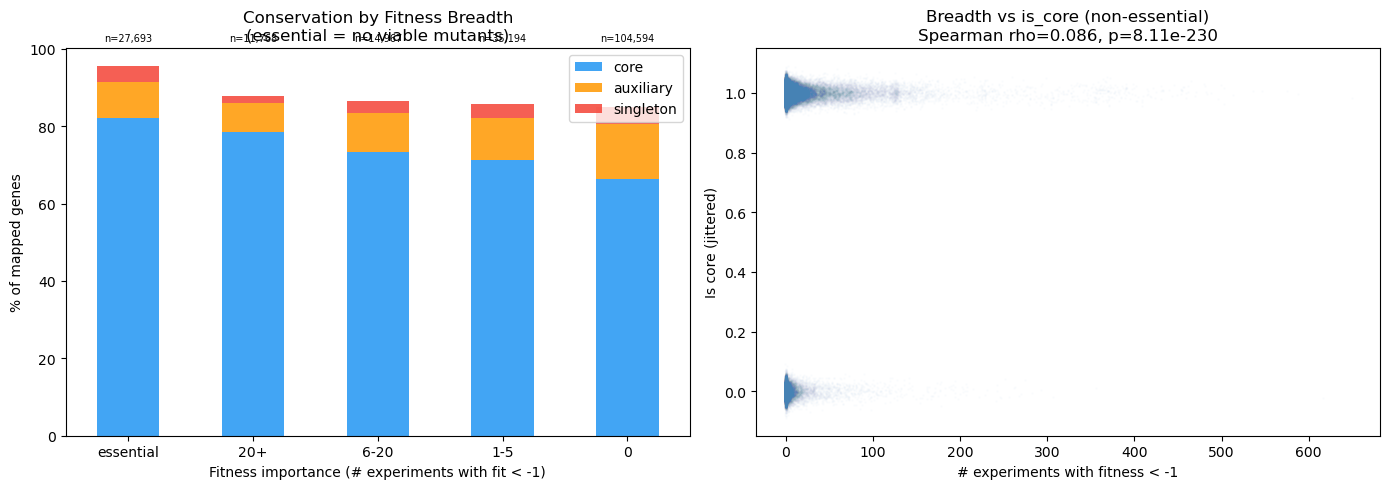

=== CONSERVATION BY BREADTH (including essential) ===
conservation  core  auxiliary  singleton  unmapped
breadth_bin                                       
essential     82.2        9.3        4.0       4.5
20+           78.6        7.4        1.9      12.1
6-20          73.2       10.1        3.2      13.4
1-5           71.3       10.9        3.5      14.3
0             66.4       14.2        4.2      15.2


In [2]:
# Bin genes by n_sick — include essential as the extreme
non_ess = merged[~merged['is_essential']].copy()
bins = [-1, 0, 5, 20, 1000]
labels = ['0', '1-5', '6-20', '20+']
non_ess['breadth_bin'] = pd.cut(non_ess['n_sick'], bins=bins, labels=labels)

merged['breadth_bin'] = 'essential'
merged.loc[~merged['is_essential'], 'breadth_bin'] = non_ess['breadth_bin'].astype(str)

bin_order = ['essential', '20+', '6-20', '1-5', '0']
cat_order = ['core', 'auxiliary', 'singleton', 'unmapped']

breadth_cons = pd.crosstab(merged['breadth_bin'], merged['conservation'], normalize='index') * 100
breadth_cons = breadth_cons[[c for c in cat_order if c in breadth_cons.columns]]
breadth_cons = breadth_cons.reindex([b for b in bin_order if b in breadth_cons.index])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

breadth_cons[['core', 'auxiliary', 'singleton']].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=['#2196F3', '#FF9800', '#F44336'], alpha=0.85)
axes[0].set_ylabel('% of mapped genes')
axes[0].set_xlabel('Fitness importance (# experiments with fit < -1)')
axes[0].set_title('Conservation by Fitness Breadth\n(essential = no viable mutants)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='')

for i, lbl in enumerate(breadth_cons.index):
    n = (merged['breadth_bin'] == lbl).sum()
    axes[0].text(i, 102, f'n={n:,}', ha='center', fontsize=7)

# Spearman: n_sick vs is_core (non-essential mapped only)
mapped_ne = merged[(~merged['is_essential']) & merged['is_mapped']]
rho, pval = stats.spearmanr(mapped_ne['n_sick'], mapped_ne['is_core'].astype(int))
axes[1].scatter(mapped_ne['n_sick'] + np.random.normal(0, 0.3, len(mapped_ne)),
                mapped_ne['is_core'].astype(float) + np.random.normal(0, 0.02, len(mapped_ne)),
                alpha=0.01, s=1, color='steelblue')
axes[1].set_xlabel('# experiments with fitness < -1')
axes[1].set_ylabel('Is core (jittered)')
axes[1].set_title(f'Breadth vs is_core (non-essential)\nSpearman rho={rho:.3f}, p={pval:.2e}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fitness_breadth_vs_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== CONSERVATION BY BREADTH (including essential) ===")
print(breadth_cons.round(1).to_string())

## B. Specific Phenotype Genes

In [3]:
# Are specific-phenotype genes more likely auxiliary/singleton?
merged['has_specific'] = merged['n_specific_phenotypes'] > 0

spec_cons = pd.crosstab(merged['has_specific'], merged['conservation'], normalize='index') * 100
spec_cons = spec_cons[[c for c in cat_order if c in spec_cons.columns]]

print("=== CONSERVATION: SPECIFIC PHENOTYPE vs NO SPECIFIC PHENOTYPE ===")
print(spec_cons.round(1).to_string())
print(f"\nGenes with specific phenotypes: {merged['has_specific'].sum():,}")
print(f"Genes without: {(~merged['has_specific']).sum():,}")

# Fisher's exact: specific phenotype genes vs core
sp_core = merged[merged['has_specific'] & (merged['conservation'] == 'core')].shape[0]
sp_not_core = merged[merged['has_specific'] & (merged['conservation'] != 'core') & merged['is_mapped']].shape[0]
no_sp_core = merged[~merged['has_specific'] & (merged['conservation'] == 'core')].shape[0]
no_sp_not_core = merged[~merged['has_specific'] & (merged['conservation'] != 'core') & merged['is_mapped']].shape[0]

odds, p = stats.fisher_exact([[sp_core, sp_not_core], [no_sp_core, no_sp_not_core]])
print(f"\nSpecific phenotype vs core: OR={odds:.2f}, p={p:.2e}")
print(f"  (OR > 1 means specific-phenotype genes are MORE likely core)")

=== CONSERVATION: SPECIFIC PHENOTYPE vs NO SPECIFIC PHENOTYPE ===
conservation  core  auxiliary  singleton  unmapped
has_specific                                      
False         70.3       12.5        3.9      13.2
True          77.3        7.8        2.3      12.5

Genes with specific phenotypes: 13,476
Genes without: 180,740

Specific phenotype vs core: OR=1.78, p=1.82e-97
  (OR > 1 means specific-phenotype genes are MORE likely core)


## C. Condition Type and Conservation

Do different experimental condition types reveal different conservation patterns?
Hypothesis: carbon source fitness genes may be more accessory (metabolic flexibility),
while stress genes may be more core (universal survival).

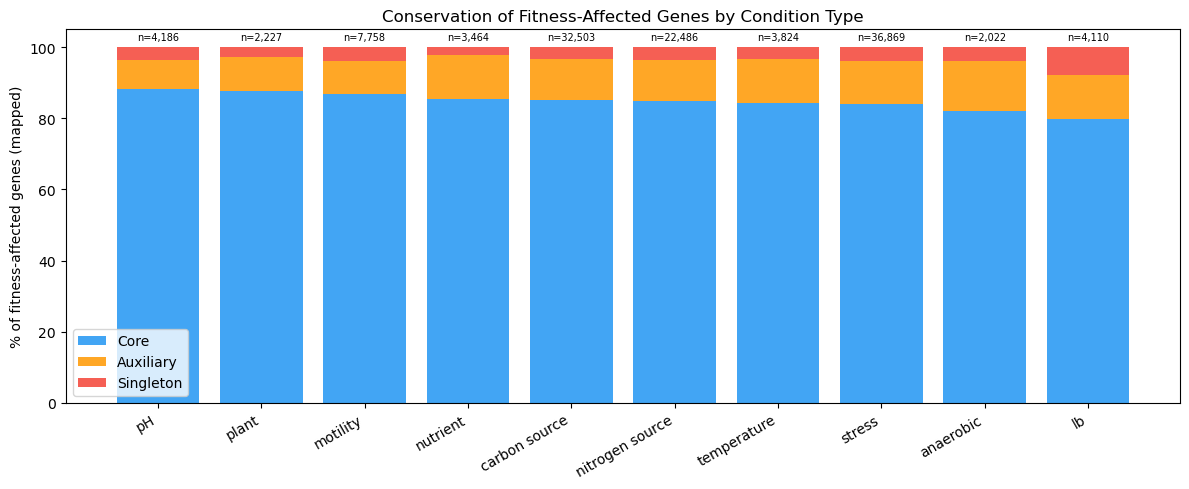

=== CONSERVATION OF SICK GENES BY CONDITION TYPE ===
      condition  n_sick_genes  pct_core  pct_auxiliary  pct_singleton
             pH          4186      88.3            8.1            3.6
          plant          2227      87.7            9.6            2.8
       motility          7758      86.7            9.4            3.9
       nutrient          3464      85.4           12.4            2.1
  carbon source         32503      85.1           11.7            3.2
nitrogen source         22486      84.9           11.4            3.7
    temperature          3824      84.4           12.1            3.5
         stress         36869      84.1           12.0            3.9
      anaerobic          2022      82.1           14.1            3.8
             lb          4110      79.9           12.2            7.9


In [4]:
# Add conservation to by_cond data
cond_merged = by_cond.merge(
    link[['orgId', 'locusId', 'is_core', 'is_singleton', 'gene_cluster_id']],
    on=['orgId', 'locusId'], how='left'
)
cond_merged['is_mapped'] = cond_merged['gene_cluster_id'].notna()
cond_merged['conservation'] = 'unmapped'
cond_merged.loc[cond_merged['is_mapped'] & (cond_merged['is_core'] == True), 'conservation'] = 'core'
cond_merged.loc[cond_merged['is_mapped'] & (cond_merged['is_singleton'] == True), 'conservation'] = 'singleton'
cond_merged.loc[cond_merged['is_mapped'] & (cond_merged['is_core'] != True) &
                (cond_merged['is_singleton'] != True), 'conservation'] = 'auxiliary'

# For each condition type, fraction of sick genes (fit < -1) that are core
sick_genes = cond_merged[cond_merged['n_sick'] > 0]

# Top condition types by frequency
top_conditions = sick_genes['expGroup'].value_counts().head(10).index.tolist()

cond_cons = []
for cond in top_conditions:
    d = sick_genes[sick_genes['expGroup'] == cond]
    mapped_d = d[d['is_mapped']]
    if len(mapped_d) < 10:
        continue
    cond_cons.append({
        'condition': cond,
        'n_sick_genes': len(d),
        'pct_core': (mapped_d['conservation'] == 'core').mean() * 100,
        'pct_auxiliary': (mapped_d['conservation'] == 'auxiliary').mean() * 100,
        'pct_singleton': (mapped_d['conservation'] == 'singleton').mean() * 100,
    })

cond_df = pd.DataFrame(cond_cons).sort_values('pct_core', ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
x = range(len(cond_df))
ax.bar(x, cond_df['pct_core'], label='Core', color='#2196F3', alpha=0.85)
ax.bar(x, cond_df['pct_auxiliary'], bottom=cond_df['pct_core'],
       label='Auxiliary', color='#FF9800', alpha=0.85)
ax.bar(x, cond_df['pct_singleton'],
       bottom=cond_df['pct_core'] + cond_df['pct_auxiliary'],
       label='Singleton', color='#F44336', alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(cond_df['condition'], rotation=30, ha='right')
ax.set_ylabel('% of fitness-affected genes (mapped)')
ax.set_title('Conservation of Fitness-Affected Genes by Condition Type')
ax.legend()

for i, (_, row) in enumerate(cond_df.iterrows()):
    ax.text(i, 102, f'n={row["n_sick_genes"]:,.0f}', ha='center', fontsize=7)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'conservation_by_condition_type.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== CONSERVATION OF SICK GENES BY CONDITION TYPE ===")
print(cond_df.round(1).to_string(index=False))

## D. Broad vs Specific Fitness and Conservation

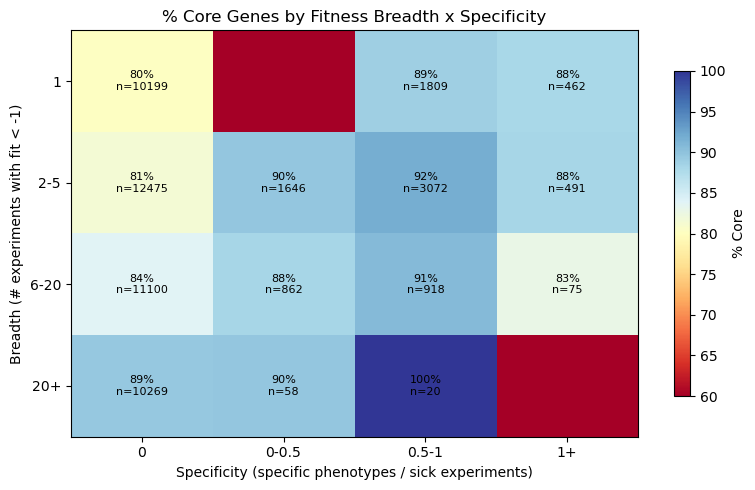

In [5]:
# 2D: breadth x specificity
# Specificity = n_specific_phenotypes / n_sick (how targeted are the effects)
has_effect = merged[merged['n_sick'] > 0].copy()
has_effect['specificity'] = has_effect['n_specific_phenotypes'] / has_effect['n_sick']
has_effect['specificity'] = has_effect['specificity'].clip(0, 5)

breadth_bins = [-1, 1, 5, 20, 1000]
breadth_labels = ['1', '2-5', '6-20', '20+']
spec_bins = [-0.01, 0, 0.5, 1, 100]
spec_labels = ['0', '0-0.5', '0.5-1', '1+']

has_effect['breadth_cat'] = pd.cut(has_effect['n_sick'], bins=breadth_bins, labels=breadth_labels)
has_effect['spec_cat'] = pd.cut(has_effect['specificity'], bins=spec_bins, labels=spec_labels)

# Heatmap: % core in each breadth x specificity cell
mapped_eff = has_effect[has_effect['is_mapped']]
heat = mapped_eff.groupby(['breadth_cat', 'spec_cat'], observed=True)['is_core'].mean() * 100
heat_pivot = heat.unstack()

# Fill NaN with 0 and convert to float for imshow
heat_values = heat_pivot.values.astype(float)
heat_values[np.isnan(heat_values)] = 0

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(heat_values, cmap='RdYlBu', aspect='auto', vmin=60, vmax=100)
ax.set_xticks(range(len(heat_pivot.columns)))
ax.set_xticklabels(heat_pivot.columns)
ax.set_yticks(range(len(heat_pivot.index)))
ax.set_yticklabels(heat_pivot.index)
ax.set_xlabel('Specificity (specific phenotypes / sick experiments)')
ax.set_ylabel('Breadth (# experiments with fit < -1)')
ax.set_title('% Core Genes by Fitness Breadth x Specificity')
plt.colorbar(im, label='% Core', shrink=0.8)

# Add text
for i in range(len(heat_pivot.index)):
    for j in range(len(heat_pivot.columns)):
        val = heat_values[i, j]
        n = mapped_eff[(mapped_eff['breadth_cat'] == heat_pivot.index[i]) &
                       (mapped_eff['spec_cat'] == heat_pivot.columns[j])].shape[0]
        if n > 0:
            ax.text(j, i, f'{val:.0f}%\nn={n}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'broad_vs_specific_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [6]:
print("=" * 60)
print("NB03 SUMMARY: Fitness Breadth & Condition Type")
print("=" * 60)
print(f"Total genes: {len(merged):,} ({merged['is_essential'].sum():,} essential)")
print(f"Organisms: {merged['orgId'].nunique()}")
print(f"Breadth-core Spearman (non-essential): rho={rho:.3f}, p={pval:.2e}")
print(f"Genes with specific phenotypes: {merged['has_specific'].sum():,}")
print(f"Condition types analyzed: {len(cond_df)}")
print("=" * 60)

NB03 SUMMARY: Fitness Breadth & Condition Type
Total genes: 194,216 (27,693 essential)
Organisms: 43
Breadth-core Spearman (non-essential): rho=0.086, p=8.11e-230
Genes with specific phenotypes: 13,476
Condition types analyzed: 10
